## importando a base de dados nescessaria

In [1]:
!pip install mlforecast
!pip install lightgbm
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import pickle

import mlforecast
from mlforecast import MLForecast

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from mlforecast import MLForecast
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

### Funções

In [3]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## Importando a base de dados

In [4]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [5]:
data = pd.read_parquet(bucket_uri)

In [6]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [7]:
data['id'].nunique()

30490

In [8]:
data['item_id'].nunique()

3049

In [9]:
data['dept_id'].nunique()

7

In [10]:
data['cat_id'].nunique()

3

In [11]:
data['store_id'].nunique()

10

In [12]:
data['state_id'].nunique()

3

In [13]:
data['date'] = pd.to_datetime(data['date'])

In [14]:
data = data.set_index('date')

## Previsão por estado (state_id):✅


In [15]:
df_state_id = data.groupby(['state_id']).resample('M')['value'].sum()

In [16]:
df_state_id.to_frame()

value
state_id date              
CA       2011-01-31   38108
         2011-02-28  318101
         2011-03-31  339678
         2011-04-30  331004
         2011-05-31  321566
...                     ...
WI       2016-01-31  368104
         2016-02-29  379113
         2016-03-31  393142
         2016-04-30  401284
         2016-05-31  310637

[195 rows x 1 columns]

In [17]:
df_state_id_reset_index = df_state_id.reset_index()

In [18]:
df_nixtla_6 = pd.DataFrame({
    'unique_id': df_state_id_reset_index['state_id'],
    'ds': df_state_id_reset_index['date'],
    'y': df_state_id_reset_index['value']
})

In [19]:
df_nixtla_6

,unique_id,ds,y
0,CA,2011-01-31,38108
1,CA,2011-02-28,318101
2,CA,2011-03-31,339678
3,CA,2011-04-30,331004
4,CA,2011-05-31,321566
...,...,...,...
190,WI,2016-01-31,368104
191,WI,2016-02-29,379113
192,WI,2016-03-31,393142
193,WI,2016-04-30,401284


In [20]:
df_nixtla_6['ds'] = pd.to_datetime(df_nixtla_6['ds'])

In [21]:
df_nixtla_6['unique_id'].value_counts().sum()

195

In [22]:
df_test = df_nixtla_6.groupby('unique_id').tail(6)
df_train = df_nixtla_6.drop(df_test.index)

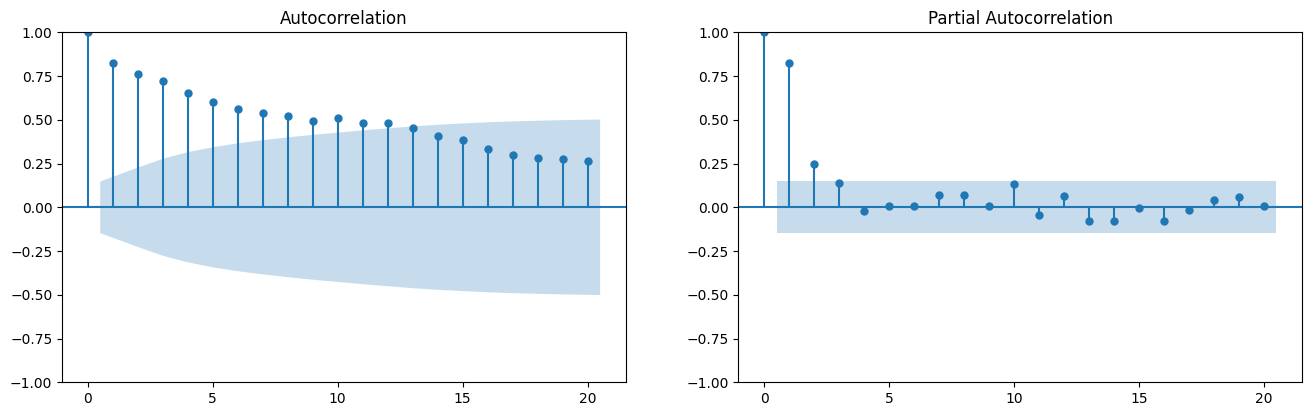

In [23]:
acf_pacf(df_train['y'], 20)

In [24]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor()
}

In [25]:
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[x for x in range(1, 12)],
)

In [26]:
fcst.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 11
[LightGBM] [Info] Start training from score 360064.159722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

MLForecast(models=[RandomForestRegressor, LinearRegression, MLPRegressor, KNeighborsRegressor, XGBRegressor, LGBMRegressor], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11'], date_features=[], num_threads=1)

In [27]:
len(df_test)

18

In [28]:
predict = fcst.predict(6)


In [29]:
for i in list(models.keys()):
  predict[i] = predict[i].astype(int)

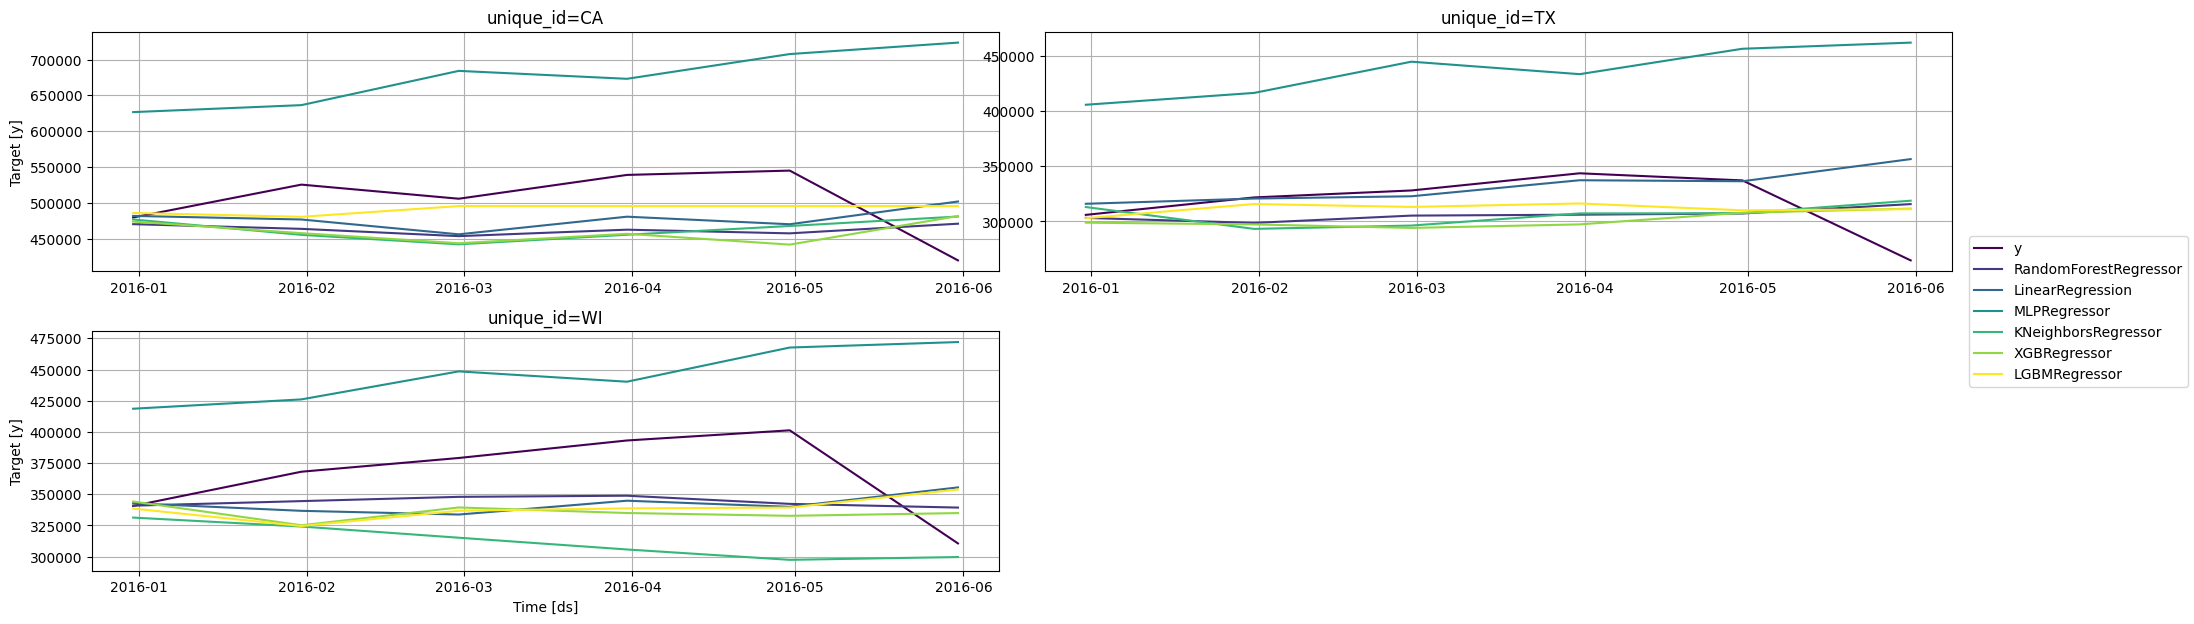

In [30]:
plot_series(df_test, predict, plot_random=False)

In [31]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], predict[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], predict[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], predict[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], predict[i])
  print(f'R2: {R2}')
  print('\n')

------------------RandomForestRegressor-----------------
Mean Absolute Error: 38475.333333333336
Mean absolute percentage error: 0.09470113998979642
Root mean squared error: 45041.59963238922
R2: 0.7233655935760326


------------------LinearRegression-----------------
Mean Absolute Error: 36909.166666666664
Mean absolute percentage error: 0.0937424070756212
Root mean squared error: 47347.46107648106
R2: 0.6943165162814078


------------------MLPRegressor-----------------
Mean Absolute Error: 124193.72222222222
Mean absolute percentage error: 0.3252481320013004
Root mean squared error: 138136.7091316505
R2: -1.601937100728395


------------------KNeighborsRegressor-----------------
Mean Absolute Error: 48086.61111111111
Mean absolute percentage error: 0.11925248929530609
Root mean squared error: 56427.07499409206
R2: 0.5658361502640957


------------------XGBRegressor-----------------
Mean Absolute Error: 44896.944444444445
Mean absolute percentage error: 0.11018746235513227
Root mean s

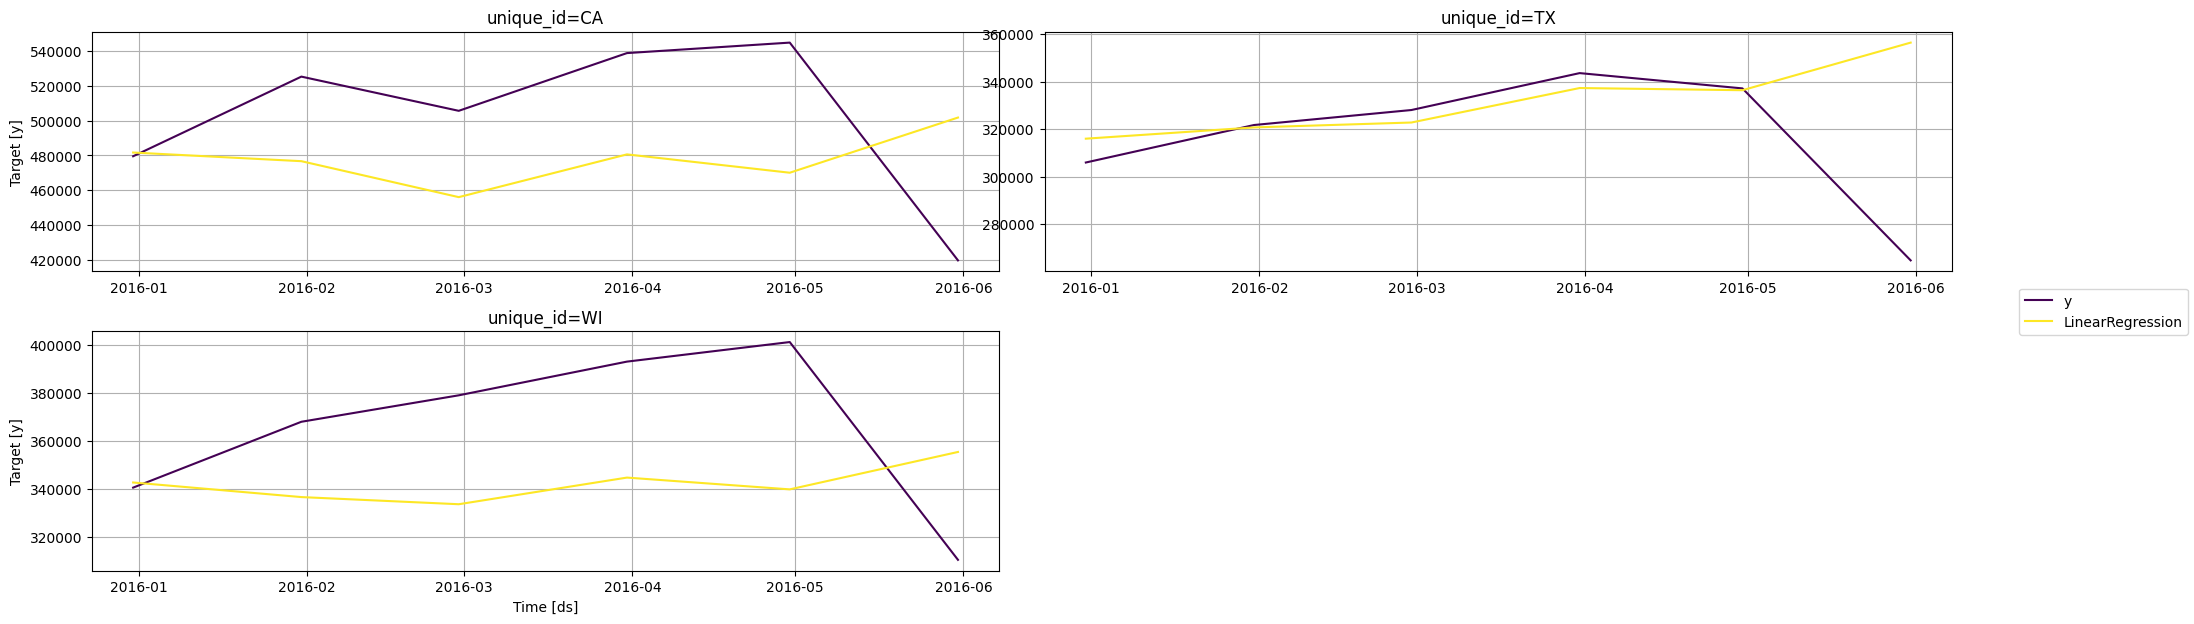

In [32]:
plot_series(df_test, predict[['unique_id', 'ds', 'LinearRegression']], plot_random=False)

In [33]:
previsao = df_test.merge(predict, how='right', on=['unique_id', 'ds'])
previsao.head()

,unique_id,ds,y,RandomForestRegressor,LinearRegression,MLPRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor
0,CA,2015-12-31,479557,470190,481699,626620,476728,473821,485858
1,CA,2016-01-31,525392,463657,476721,636354,455310,457639,480438
2,CA,2016-02-29,505704,453488,456030,684174,442021,443540,495438
3,CA,2016-03-31,538930,462503,480631,673103,455409,456739,495438
4,CA,2016-04-30,544960,457369,470077,707650,467659,441640,495438


In [34]:
previsao.to_csv('treinamento/treino_estados_treino.csv')

In [35]:
models = {
    'LinearRegression' : LinearRegression()
}

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 6, 12]
)


In [36]:
dados_full = pd.concat([df_train, df_test])
fcst.fit(dados_full)

MLForecast(models=[LinearRegression], freq=MS, lag_features=['lag1', 'lag6', 'lag12'], date_features=[], num_threads=1)

In [37]:
import pickle
with open('Modelos/modelo_previsao_estados.pkl', 'wb') as file:
    pickle.dump(fcst, file)

In [38]:
previsao = fcst.predict(6)
previsao['LinearRegression'] = previsao['LinearRegression'].astype(int)
previsao

,unique_id,ds,LinearRegression
0,CA,2016-06-01,436191
1,CA,2016-07-01,455932
2,CA,2016-08-01,472708
3,CA,2016-09-01,484631
4,CA,2016-10-01,496500
5,CA,2016-11-01,489781
6,TX,2016-06-01,282899
7,TX,2016-07-01,300553
8,TX,2016-08-01,314650
9,TX,2016-09-01,323944


In [39]:
previsao.to_csv('previsao/previsao_estados_lgbm.csv')